# Definición de Paseo Aleatorio, Regresión y Modelos de Ruido Blanco

### MSC. Econometricas Helton Eduardo Acosta
### acostahelton123@gmail.com

***

## En esta sesión...

1. Correlograma y fórmula de Bartlett (ejemplos)
2. Paseo aleatorio y ruido blanco
3. Regresión lineal (Una introducción)

***

## 0. Primero, leamos los datos

Dataset extraido de: [S&P 500 (SPX) Historical Data - Nasdaq](https://www.nasdaq.com/market-activity/index/spx/historical?page=5&rows_per_page=10&timeline=y5)

In [ ]:
pip install fbm

In [ ]:
# Importamos librerías básicas de Python
import numpy as np # vectores y matrices
from fbm import FBM # Movimiento Browniano fraccional (solo como ejemplo) no es necesario en general
import pandas as pd # dataframes
import statsmodels.api as sm # lib. general de Statsmodels
import matplotlib.pyplot as plt # ploteo básico
from statsmodels.tsa.stattools import acf # func. de autocorr.
from statsmodels.graphics.tsaplots import plot_acf # func. de correlograma

In [ ]:
# Leemos los el .CSV ("comma-separated value") como Dataframe
data = pd.read_csv("/content/HistoricalData_1717625532707.csv")

Observemos los valores iniciales y finales.

In [ ]:
# Valores iniciales
data.head()

,Date,Close/Last,Open,High,Low
0,06/04/2024,5291.34,5278.24,5298.80,5257.63
1,06/03/2024,5283.40,5297.15,5302.11,5234.32
2,05/31/2024,5277.51,5243.21,5280.33,5191.68
3,05/30/2024,5235.48,5259.77,5260.21,5222.10
4,05/29/2024,5266.95,5278.73,5282.27,5262.70


In [ ]:
# Valores finales
data.tail()

,Date,Close/Last,Open,High,Low
1254,06/11/2019,2885.72,2903.27,2910.61,2878.53
1255,06/10/2019,2886.73,2885.83,2904.77,2885.51
1256,06/07/2019,2873.34,2852.87,2884.97,2852.87
1257,06/06/2019,2843.49,2828.51,2852.10,2822.45
1258,06/05/2019,2826.15,2818.09,2827.28,2800.92


Notamos que los datos están invertidos temporalmente. Entonces, ordenémoslo, de modo tal que primero tengamos las fechas más antiguas y, al final, las más recientes.

In [ ]:
# Invirtiendo orden del dataframe
data = data[::-1].reset_index(drop=True)

In [ ]:
# Imprimamos la primera fecha y la última
print(f">> Fecha más antigua: {data.Date.iloc[0]}")
print(f">> Fecha más reciente: {data.Date.iloc[-1]}")

>> Fecha más antigua: 06/05/2019
>> Fecha más reciente: 06/04/2024


Ahora, veamos el tipo de cada categoría en nuestro dataset y visualicemos la serie:

In [ ]:
# Tipo de dato por columna
data.dtypes

Date           object
Close/Last    float64
Open          float64
High          float64
Low           float64
dtype: object

Notamos que el tipo de dato `Date` es un objeto. Sería mejor definirlo como un `Datetime`.

In [ ]:
# Por ejemplo si extraigo un elmento de la columna fecha (Date), este sera de tipo str.
type(data.Date.iloc[0])

str

In [ ]:
# Tengo que convertir la columna `Date` a formato pd.datetime
data.Date = pd.to_datetime(data.Date)
data.dtypes

Date          datetime64[ns]
Close/Last           float64
Open                 float64
High                 float64
Low                  float64
dtype: object

Finalmente, ploteamos nuestra serie de tiempo.

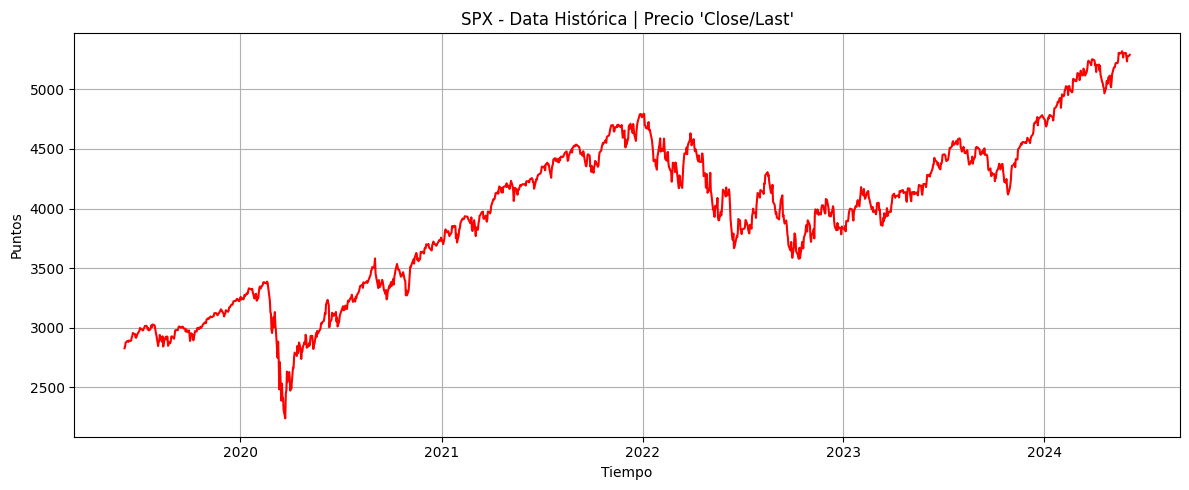

In [ ]:
# Ploteamos la serie utilizando la columna 'Close/Last'
plt.figure(figsize=(12,5)) # tamano del plot
plt.plot(data["Date"], data["Close/Last"], color="red")
plt.xlabel("Tiempo")
plt.ylabel("Puntos")
plt.title("SPX - Data Histórica | Precio 'Close/Last'")
plt.grid(True)
plt.tight_layout()
plt.show()

Para fines de la presente clase, definiremos un dataframe tomando en cuenta únicamente la columna `Close/Last`, que definiremos por conveniencia como `Price` en una variable llamada `timeSeries`. La columna `Date` también estará incluida.

In [ ]:
# Definiendo nueva variable para trabajar
timeSeries = data[["Date", "Close/Last"]].rename(columns={'Close/Last': 'Price'})
timeSeries.head()

,Date,Price
0,2019-06-05,2826.15
1,2019-06-06,2843.49
2,2019-06-07,2873.34
3,2019-06-10,2886.73
4,2019-06-11,2885.72


<Axes: >

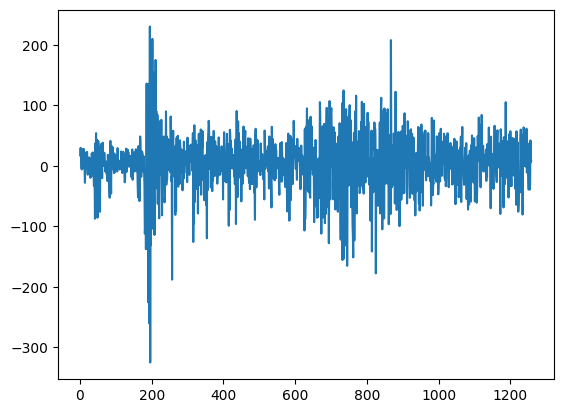

In [ ]:
timeSeries.Price.diff().plot()

***

## 1. Correlograma - Primeros ejemplos

Recordar que nuestra función de autocorrelación, para una serie $\{X\}_t$, se define como:

$$
ACF(k):=r_{\rho, k}(X) \space\space\space\space\space \forall k=1:n
$$

donde:

$$
r_{\rho, k}(X) = \frac{c_k(X)}{c_0(X)} \space\space\space\space,\space \text{tal que: } c_k(X)=\frac{1}{n}\sum_{t=1}^{n-k}(x_t - \bar{X})(x_{t+k}-\bar{X})
$$

siendo $\bar{X} = \sum_{} $ la media muestral y $c_k$ la autocovarianza muestral.

Entonces, empecemos creando una función en Python que siga esta fórmula:

In [ ]:
# Función para calcular el ACF usando nuestra fórmula de la Sesión 2
def acf_manual(x, nlags):

    # Calcular X barra, es decir, la media de la serie temporal
    x_mean = np.mean(x)

    # Calcular c0 (varianza), ya que es constante (k=0)
    c0 = np.sum((x - x_mean) ** 2) / len(x)

    # Inicializar la lista de autocorrelaciones (ACF = 1 en K = 0)
    acf_values = [1.0]

    # Calcular autocorrelaciones para cada retardo k
    for k in range(1, nlags + 1): # range(1, 10) = 1, 2, ..., 9
        # Calcular ck
        ck = np.sum((x[:len(x)-k] - x_mean) * (x[k:] - x_mean)) / len(x)

        # Calcular el coeficiente de autocorrelación rk
        r_k = ck / c0

        # Agregar r_k a la lista de valores ACF
        acf_values.append(r_k)

    return np.array(acf_values)

Ahora, obtengamos las autocorrelaciones con nuestra data para $k=50$:

In [ ]:
# Calcular el ACF usando nuestra función
acf_vals_manual = acf_manual(timeSeries.Price.values, nlags = 50)
acf_vals_manual

array([1.        , 0.99470259, 0.98996923, 0.98502564, 0.98033621,
       0.97572286, 0.97079408, 0.96637979, 0.96140736, 0.95684752,
       0.9515394 , 0.94657651, 0.94155187, 0.93653693, 0.93174781,
       0.92674566, 0.92219568, 0.91748121, 0.91306328, 0.90851122,
       0.90396016, 0.8994561 , 0.8948781 , 0.89092839, 0.88714123,
       0.88339901, 0.87959747, 0.87605365, 0.8723445 , 0.86854943,
       0.86471127, 0.86118085, 0.85782654, 0.85445508, 0.85112386,
       0.84764631, 0.84401669, 0.84005423, 0.83599919, 0.83199943,
       0.8279527 , 0.82400544, 0.82029903, 0.81641054, 0.81243544,
       0.80848716, 0.80440671, 0.80039755, 0.79612244, 0.79216934,
       0.78805088])

Finalmente, ploteemos los resultados:

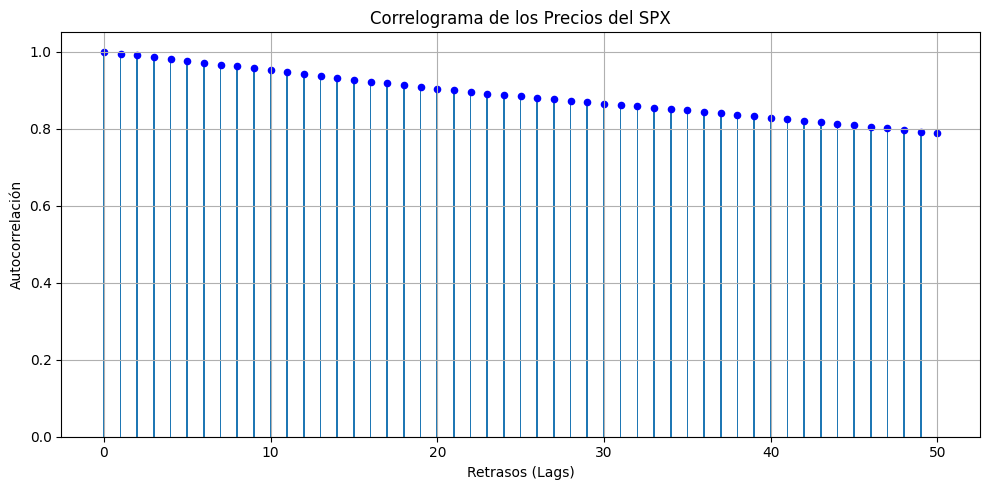

In [ ]:
# Graficar el correlograma
plt.figure(figsize=(10, 5))

# Graficar las barras de autocorrelación
plt.bar(range(50 + 1), acf_vals_manual, width=0.1)
plt.scatter(range(50 + 1), acf_vals_manual, s=20, color="blue")

# Etiquetas y título del gráfico
plt.title('Correlograma de los Precios del SPX')
plt.xlabel('Retrasos (Lags)')
plt.ylabel('Autocorrelación')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

Usualmente, no necesitamos seguir esta fórmula en Python, ya que podemos utilizar la librería `statsmodel`; en particular, la funcionalidad `acf` para obtener las autocorrelaciones, o `plot_acf` para obtener directamente el correlograma.

Primero, obtengamos las correlaciones con `statsmodel`:

In [ ]:
# ACF de statsmodel, con lag 50
acf_sm = acf(timeSeries['Price'], nlags=50)
acf_sm

array([1.        , 0.99470259, 0.98996923, 0.98502564, 0.98033621,
       0.97572286, 0.97079408, 0.96637979, 0.96140736, 0.95684752,
       0.9515394 , 0.94657651, 0.94155187, 0.93653693, 0.93174781,
       0.92674566, 0.92219568, 0.91748121, 0.91306328, 0.90851122,
       0.90396016, 0.8994561 , 0.8948781 , 0.89092839, 0.88714123,
       0.88339901, 0.87959747, 0.87605365, 0.8723445 , 0.86854943,
       0.86471127, 0.86118085, 0.85782654, 0.85445508, 0.85112386,
       0.84764631, 0.84401669, 0.84005423, 0.83599919, 0.83199943,
       0.8279527 , 0.82400544, 0.82029903, 0.81641054, 0.81243544,
       0.80848716, 0.80440671, 0.80039755, 0.79612244, 0.79216934,
       0.78805088])

Comprobemos que son exactamente las mismas que con nuestra función (hasta 10 decimales):

In [ ]:
print(f">> Autocorrelaciones iguales? : \
{np.all(np.round(acf_vals_manual, 10) == np.round(acf_sm, 10))}")

>> Autocorrelaciones iguales? : True


Ahora, obtengamos el plot correspondiente al correlograma con `plot_acf`. Note que no debemos calcular los valores de autocorrelación, ya que `statsmodel` lo hará por nosotros.

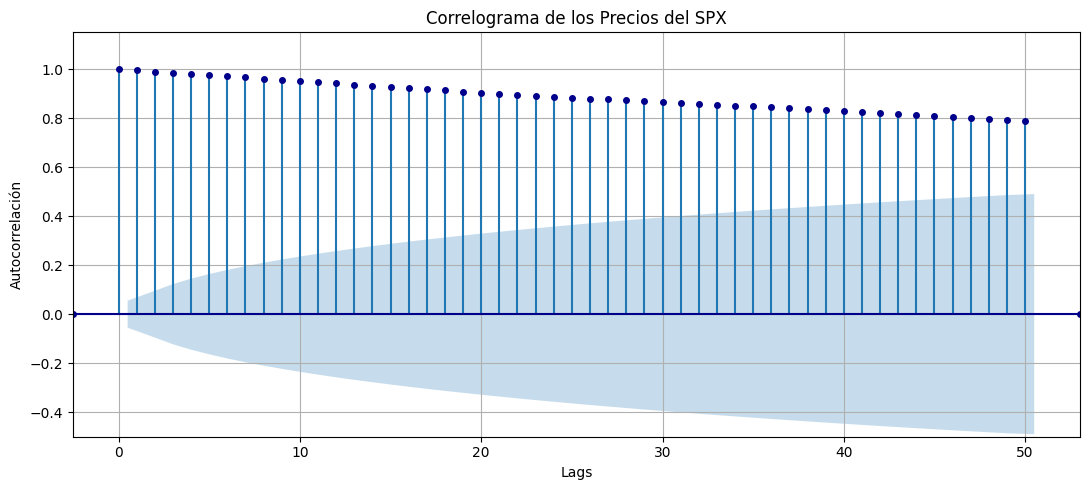

In [ ]:
# Tamaño del plot
fig, ax = plt.subplots(figsize=(11, 5))

# Crear y ajustar el correlograma con 50 rezagos (lag) | Func. de statsmodel
plot_acf(timeSeries['Price'],
         lags=50, ax=ax,
         color='darkblue',
         marker='o', markersize=4)

# Ajustes adicionales para la presentación
ax.set_title('Correlograma de los Precios del SPX')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelación')
ax.grid(True)
ax.set_ylim(-0.5, 1.15)

# Mostrar el plot
plt.tight_layout()
plt.show()

### IMPORTANTE: ¿qué es la zona sombreada?

La zona sombreada en el correlograma representa **los intervalos de confianza para los coeficientes de autocorrelación en diferentes retrasos**. Estos intervalos ayudan a determinar si las autocorrelaciones observadas son estadísticamente significativas, o no. A nivel general, todo valor de autocorrelación (todo punto de cada barra) fuera de esta área significa que dicha autocorrelación es estadísticamente relevante y, por tanto, NO puede ser omitida.

En nuestro dataset, tenemos:

In [ ]:
print(f">> N = {timeSeries.shape[0]}")

>> N = 1259


Evaluemos hasta $k=3$ a partir de los datos obtenidos para la función $\text{ACF}(X)$ de `statsmodel`. Redondeemos cada valor a solo $4$ decimales por conveniencia.

In [ ]:
# Redondeamos cada valor a 4 decimales hasta k = 3
acf_ejemplo_k5 = np.round(acf_sm[:4], 4) # note que usamos '4' ya que el primer valor es k = 0
print(f">> ACF(X, k=5): {acf_ejemplo_k5}")

>> ACF(X, k=5): [1.     0.9947 0.9897 0.9846]


Entonces, omitiendo $k=0$, tenemos:

$$ \text{SE}(r_k) = \sqrt{\frac{1}{N} \left(1 + 2 \sum_{i=1}^{k-1} r_i^2 \right)} $$

1. **Retraso 1**:
   $
   \text{SE}(r_1) = \sqrt{\frac{1}{1259}\left(1+2\times0\right)} \approx 0.0282
   $
   Intervalo de Confianza:
   $
   0.9947 \pm 1.96 \times 0.0282 = [0.9394, 1.0499]
   $

2. **Retraso 2**:
   $
   \text{SE}(r_2) = \sqrt{\frac{1}{1259} \left(1 + 2 \times 0.9947^2 \right)} \approx 0.0486
   $
   Intervalo de Confianza:
   $
   0.9897 \pm 1.96 \times 0.0486 = [0.8944, 1.0850]
   $

3. **Retraso 3**:
   $
   \text{SE}(r_3) = \sqrt{\frac{1}{1259} \left(1 + 2 \times (0.9947^2 + 0.9897^2) \right)} \approx 0.06263
   $
   Intervalo de Confianza:
   $
   0.9846 \pm 1.96 \times 0.06263 = [0.8618, 1.1073]
   $


Y continuamos sucesivamente para todos los $k$.

Finalmente, comprobemos estos valores dirctamente con la función `acf` de `statsmodel`:

In [ ]:
# Bartlett IC
print(f"Barlett IC (k = 0:3): \n{acf(timeSeries.Price, nlags=3, alpha=0.05)[1]}")

Barlett IC (k = 0:3): 
[[1.         1.        ]
 [0.93942723 1.04990254]
 [0.89440969 1.08507857]
 [0.86182122 1.10731275]]


Es importante recordar que `statsmodel` calculará por defecto el intervalo de Bartlett con un nivel de confianza del $95\%$.

### IMPORTANTE: ¿cómo se vería un correlograma de una secuencia de variables aleatorias normales?

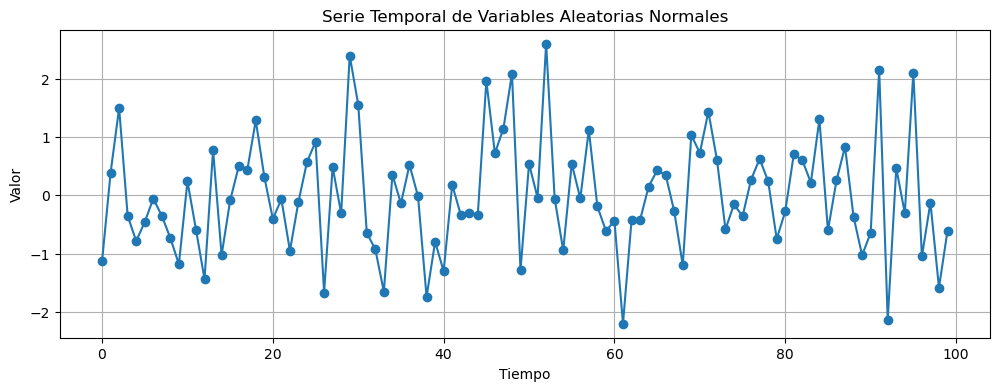

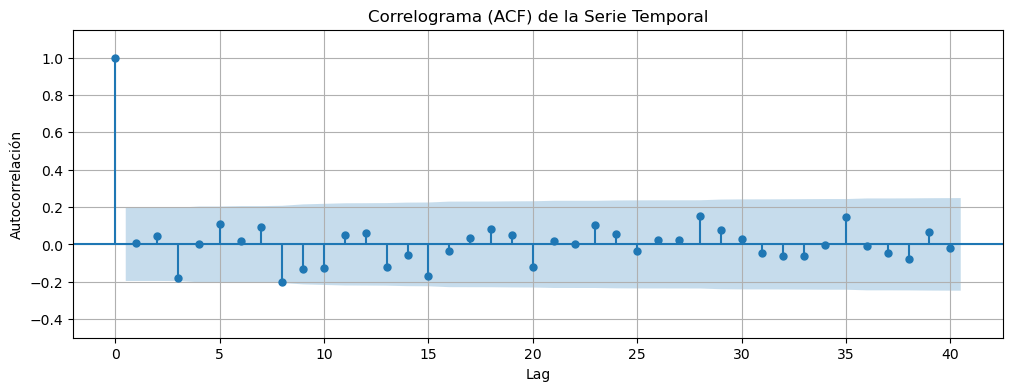

In [ ]:
# Generar una serie temporal de variables aleatorias normales
np.random.seed(111)  # Fijar la semilla para reproducibilidad
n = 100  # Número de observaciones
random_series = np.random.normal(size=n)

# Graficar la serie temporal
plt.figure(figsize=(12, 4))
plt.plot(random_series, marker='o', linestyle='-')
plt.title('Serie Temporal de Variables Aleatorias Normales')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Generar y graficar el correlograma (ACF plot)
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(random_series, lags=40, ax=ax)
ax.set_title('Correlograma (ACF) de la Serie Temporal')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelación')
ax.set_ylim(-0.5, 1.15)
plt.grid(True)
plt.show()

***

## 2. Paseo aleatorio y ruido blanco

#### 2.1 Operador Diferencial ($\nabla$)
El operador diferencial toma un elemento de una serie temporal y devuelve la diferencia entre su valor y el valor $n$ unidades de tiempo anteriormente.

$$
\nabla^n x_t = x_t - x_{t-n}
$$

$$
\nabla^n = (1 - B)^n
$$

Este operador se utiliza frecuentemente para inducir condiciones de estacionariedad en una serie temporal. La diferenciación de primer orden es suficiente en muchos casos, pero a veces se necesita una diferenciación de mayor orden para eliminar tendencias estacionales.

Sin embargo, algunos modelos (como ARFIMA, que se verá en la sesión 5) requerirán que $\nabla$ sea útil $\forall n \in \mathbb{R}$. En esos casos, $\nabla$ se denotará como $d(n)$, donde usualmente $0<n<1$.

En Python, el operador diferencial (entero) puede hallarse con el operador `diff`. Veamos un ejemplo utilizando nuestra serie del `SPX` para $\nabla^1$:

### 2.2 Series de Errores Residuales y Ruido Blanco

#### 2.2.1 Errores Residuales
La serie de errores residuales, conocida simplemente como _residuos_, es una serie temporal de las diferencias entre un valor observado y un valor predicho en un tiempo particular $t$.

> Si $y_t$ es el valor observado y $\hat{y}_t$ es el valor predicho, decimos que $e_t = y_t - \hat{y}_t$ son los residuos.

El punto clave en el análisis estándar de series de tiempo es que, si nuestro modelo de series temporales elegido es capaz de _"explicar" la correlación serial en las observaciones_, entonces **necesariamente los residuos NO estarán correlacionados serialmente**. Esto significará que cada elemento de la serie residual es una realización independiente de alguna distribución de probabilidad; es decir, los propios residuos son independientes e idénticamente distribuidos ($\text{i.i.d.}$).

#### 2.2.2 Ruido Blanco Discreto (_Discrete White Noise_, DWN)
Generado por un operador $\nabla$ sobre una serie, un DWN es cualquier serie temporal $\{W\}_{t=1:n}$ cuyos elementos son $\text{i.i.d.}$, con media constante, varianza $\sigma^2$ y sin correlación serial sobre $(t_1, t_n)$, es decir, $\text{Corr}(w_i, w_j) = 0, \space\forall i \neq j$.

> Si $w_t \sim N(0, \sigma^2)$, entonces $w_t$ es un **Ruido Blanco Gaussiano** (Gaussian White Noise).

Un ruido blanco gaussiano (estándar) tendrá $\sigma^2 = 1$.

**Propiedades de Segundo Orden del DWN**:
$$
E[w_t] = 0
$$

$$
\text{Var}(w_t) = \sigma^2
$$

$$
\text{Corr}(w_t, w_{t+k}) =
\begin{cases}
1 & \text{si } k = 0 \\
0 & \text{si } k \neq 0
\end{cases}
$$

Recordar que denominamos "_propiedades de segundo orden_" a las características que involucran a la media, la varianza y, en consecuencia, a la correlación (revisar definición de _estacionariedad débil_ de la clase 2).

La forma clásica de generar un ruido blanco gaussiano en Python es directamente utilizando Numpy, y la funcionalidad `np.random.normal(...)`.

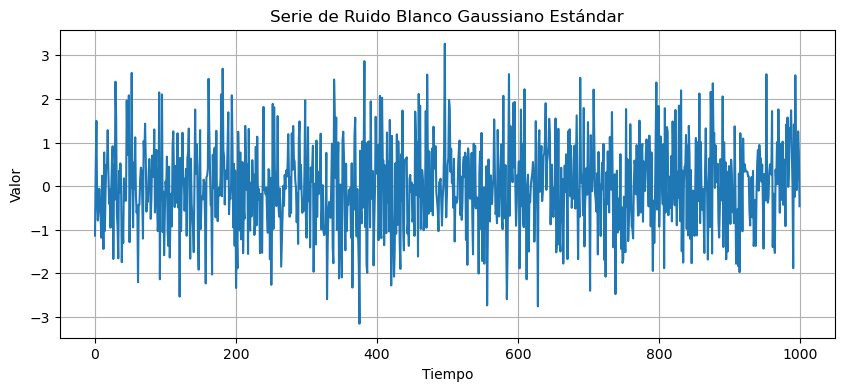

In [ ]:
# Definimos un seed para reproductibilidad
np.random.seed(111)

# Definimos el total de puntos que deseamos
n = 1000
# Definimos el ruido blanco gaussiano estándar
white_noise = np.random.normal(0, 1, n)

# Ploteamos la serie de ruido blanco
plt.figure(figsize=(10, 4))
plt.plot(white_noise)
plt.title('Serie de Ruido Blanco Gaussiano Estándar')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

### 2.3. Paseo Aleatorio

#### 2.3.1 Definición
De la primera clase, sabemos que la Ecuación Diferencial Discreta (EDD) lineal básica que modela una serie de tiempo es conocida como "paseo aleatorio", o "random walk". Este es un modelo de serie temporal donde la observación actual es igual a la observación previa más un salto aleatorio. Cuando este "salto aleatorio" es un ruido blanco $w_t$, se le conocerá como "paseo aleatorio estándar" o "random walk estándar".

$$
x_t = x_{t-1} + w_t
$$

Donde si $w_t$ es ruido blanco gaussiano, $x_t$ será un **Gaussian Random Walk**.

#### 3.3.2 Propiedades del Paseo Aleatorio
- **Media:** La media de un paseo aleatorio es $0$.
- **Varianza:** La varianza crece con el tiempo, lo que significa que es un proceso _no estacionario_.
    
$$
\mu_x = 0
$$

$$
\gamma_k(t) = \text{Cov}(x_t, x_{t+k}) = t \sigma^2
$$
    
En otras palabras, $\sigma$ crece con la $\sqrt{t}$ (es decir, a medida que el tiempo aumenta, también lo hace la varianza). Por lo tanto, _no existe tendencia determinística_ en el proceso a lo largo del tiempo (son paseos aleatorios).

- **Correlograma**: Concretamente, para un RW estándar, estará definido como.

$$
\rho_k(t) = \frac{\text{Cov}(x_t, x_{t+k})}{\sqrt{\text{Var}(x_t) \text{Var}(x_{t+k})}} = \frac{t \sigma^2}{\sqrt{t\sigma^2 (t + k) \sigma^2}} = \frac{1}{\sqrt{1 + k/t}}
$$

En Python, podemos generar un Random Walk Gaussiano Estándar fácilmente empleando la funcionalidad `np.cumsum`. Esto nos permitirá construir el paseo aleatorio sumando una serie sucesiva de ruidos blancos.

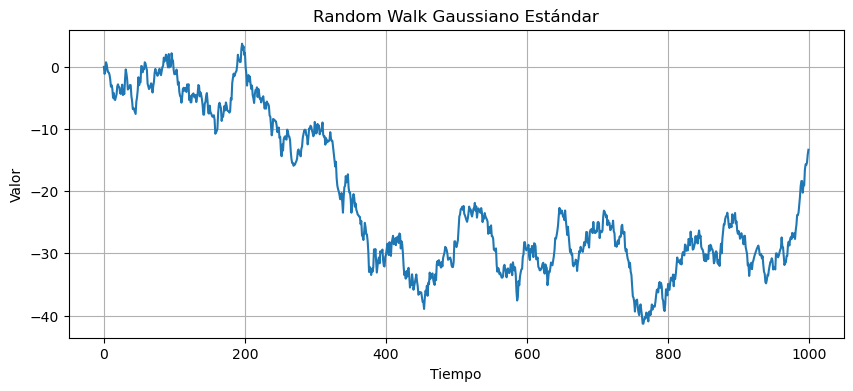

In [ ]:
# Generar un paseo aleatorio
np.random.seed(111)
# Total de puntos deseados
n = 1000
# Definimos el vector con la suma acumulada de ruidos blancos
suma_acumulada_ruidos_blancos = np.cumsum(np.random.normal(0, 1, n-1))
# Definimos un valor inicial fijo para x0, normalmente x0 = 0
random_walk = np.insert(suma_acumulada_ruidos_blancos, 0, 0)

# Plotear el paseo aleatorio
plt.figure(figsize=(10, 4))
plt.plot(random_walk)
plt.title('Random Walk Gaussiano Estándar')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

***

## 3. Regresión lineal (una introducción)

### 3.1. Definición

La regresión lineal es una técnica estadística utilizada para modelar la relación entre una variable dependiente $ y $ y una o más variables independientes $ x $. Esta técnica asume una relación lineal entre las variables.

La ecuación de regresión lineal puede ser representada como:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_r x_r + \epsilon
$$

donde:
- $ \beta_0, \beta_1, \ldots, \beta_r $ son los coeficientes de regresión.
- $ \epsilon $ es el término de error aleatorio.
- $x = (x_1, \ldots, x_r)$, donde $r$ es el número de predictores.

### 3.2. Implementación de regresión lineal (en Python)

Directamente, supongamos que tenemos el siguiente conjunto de datos:

In [ ]:
# Datos
x = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35]]
y = [4, 5, 20, 14, 32, 22, 38, 43]
x, y = np.array(x), np.array(y)
# Imprimamos X e Y
print(f">> V. Independientes (X): \n{x}")
print(f">> V. Dependientes (Y): {y}")

>> V. Independientes (X): 
[[ 0  1]
 [ 5  1]
 [15  2]
 [25  5]
 [35 11]
 [45 15]
 [55 34]
 [60 35]]
>> V. Dependientes (Y): [ 4  5 20 14 32 22 38 43]


Note que tenemos $2$ features (es decir, 2 predictores), ya que $\text{col}(X)= 2$. Ahora bien, solo como referencia, ploteemos $X\land Y$:

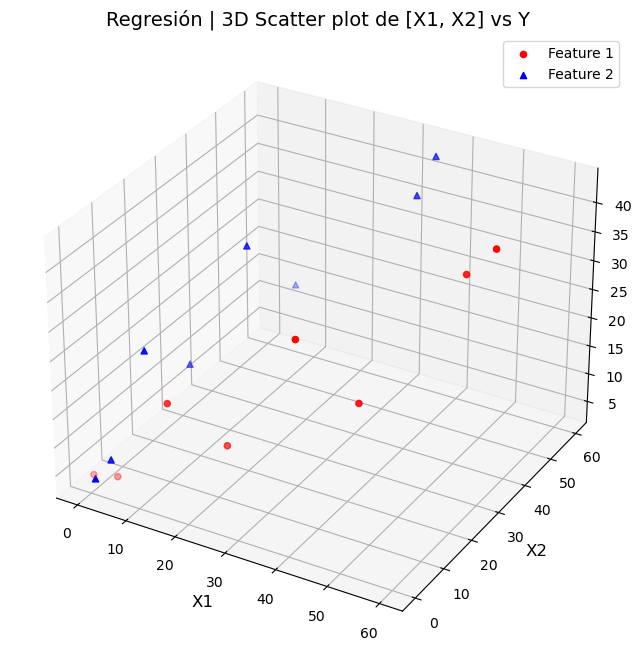

In [ ]:
# Crear la figura y el eje 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos 3D con diferentes colores
ax.scatter(x[:, 0], x[:, 1], y, c='r', marker='o', label='Feature 1')
ax.scatter(x[:, 1], x[:, 0], y, c='b', marker='^', label='Feature 2')

# Etiquetas y título
ax.set_zlabel('Y', fontsize=12)
ax.set_xlabel('X1', fontsize=12)
ax.set_ylabel('X2', fontsize=12)
ax.set_title('Regresión | 3D Scatter plot de [X1, X2] vs Y', fontsize=14)

# Añadir la leyenda
ax.legend()

# Mostrar el plot
plt.show()

Ahora bien, como vimos en la definición matricial (sección _4.3.2._, parte _A_), es necesario añadir el vector $\mathbf{1}$ como columna a las entradas de $X$ para que el modelo calcule un intercepto $b_0$.

In [ ]:
# Agregando vector 1 a x
x = sm.add_constant(x)

# Imprimamos
print(f">> Intercepto inicial (b) + V. Independientes (X) : \n{x}")
print(f">> V. Dependientes (Y): {y}")

>> Intercepto inicial (b) + V. Independientes (X) : 
[[ 1.  0.  1.]
 [ 1.  5.  1.]
 [ 1. 15.  2.]
 [ 1. 25.  5.]
 [ 1. 35. 11.]
 [ 1. 45. 15.]
 [ 1. 55. 34.]
 [ 1. 60. 35.]]
>> V. Dependientes (Y): [ 4  5 20 14 32 22 38 43]


Finalmente, basta llamar a la funcionalidad `OLS` de `sm` (statsmodel) para poder obtener los resultados de nuestra regresión lineal:

In [ ]:
# Creamos un modelo y fiteamos (ajustamos) nuestros datos
model = sm.OLS(y, x)
results = model.fit()

# Finalmente, imrprimimos los resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     15.56
Date:                Sun, 02 Jun 2024   Prob (F-statistic):            0.00713
Time:                        13:24:57   Log-Likelihood:                -24.316
No. Observations:                   8   AIC:                             54.63
Df Residuals:                       5   BIC:                             54.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5226      4.431      1.246      0.2

1. **$ R^2 $ (Coeficiente de determinación)**:
   - **Valor**: 0.862
   - **Significado**: El 86.2% de la variabilidad en $ Y $ se puede explicar por las variables $ X1 $ y $ X2 $. Esto indica que el modelo ajusta bastante bien los datos.


2. **Coeficiente para $X1$**:
   - **Valor**: 0.4471
   - **Significado**: Por cada unidad que aumenta $ X1 $, $ Y $ aumenta en 0.4471 unidades, manteniendo $ X2 $ constante. Aunque no es muy grande, es positivo, lo que sugiere una relación directa entre $ X1 $ y $ Y $.


3. **Coeficiente para $X2$**:
   - **Valor**: 0.2550
   - **Significado**: Por cada unidad que aumenta $ X2 $, $ Y $ aumenta en 0.2550 unidades, manteniendo $ X1 $ constante. Este coeficiente es menor que el de $ X1 $, indicando que $ X2 $ tiene un efecto positivo pero más pequeño en $ Y $.


4. **$ P $-valor de los coeficientes** (veremos como calculamos esto en la sesión 4):
   - **Para $X1$**: 0.178
     - **Interpretación**: Este valor es mayor que 0.05, lo que sugiere que el coeficiente de $ X1 $ no es estadísticamente significativo al nivel del 5%. Esto significa que no hay suficiente evidencia para afirmar que $ X1 $ tiene un efecto diferente de cero (significativo) sobre $ Y $.
   - **Para $X2$**: 0.598
     - **Interpretación**: Este valor también es mayor que 0.05, indicando que el coeficiente de $ X2 $ no es estadísticamente significativo al nivel del 5%. Similarmente, no hay suficiente evidencia para afirmar que $ X2 $ tiene un efecto diferente de cero sobre $ Y $.


5. **Constante (intercepto)**, o $\alpha$:
   - **Valor**: 5.5226
   - **Significado**: Cuando $ X1 $ y $ X2 $ son cero, el valor esperado de $ Y $ es aproximadamente 5.5226. Esto es el punto donde la línea de regresión corta el eje $ Y $.


En resumen:
- **$ R^2 $** alto sugiere un buen ajuste del modelo.
- **Coeficientes** positivos para $ X1 $ y $ X2 $, pero sus $ P $-valores indican que no son estadísticamente significativos en este caso.

***

***

> # Gracias

***

***